Diese Version (mit b) soll dienen, um die Evolution stattfinden zu lassen, Daten dabei aufzuzeichen, durch die später das Video erstellen wird.<br><br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output

In [2]:
%load_ext autoreload
%autoreload 2

from pylonen_utils_v5 import *
from plot_utils import *

_route = None

### Selbst fahren in Environment

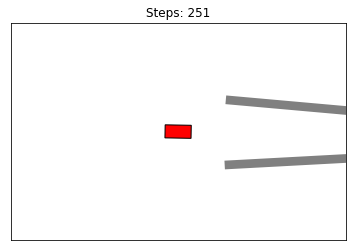

KeyboardInterrupt: 

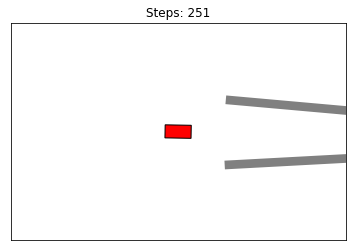

In [12]:
import keyboard

# 250 * 0.15 = T_winning

env = EnvironmentVid()
env.delt = 0.15
env.render()

for i in range(1000):
    s = 0
    if keyboard.is_pressed('ctrl'): s+=1
    if keyboard.is_pressed('alt'):  s-=1
        
    obs, reward, done, _ = env.step(s)
    
    clear_output(wait=True)
    plt.clf()
    env.render()
    plt.title(str(env.count_collisions))
    plt.title(f'Steps: {i}')
    display(plt.gcf())

### Evolutionäres Lernen des Environments
Sowohl sexuelle als auch nicht-sexuelle Reproduktion können ausprobiert werden. Beide schneiden in etwa gleich gut ab.<br>
Eine Normalverteilung zur Initialisierung erwies sich als besser, als eine Gleichmäßige Verteilung.
Am Schnellsten geht es (bei 30er Population) mit 3 reproduzierten Exemplaren.

In [4]:
from genetic_evolution import *

In [5]:
PLT_XY_EXCHANGED = True
    
def plt_plot(xs, ys, **args):
    if not PLT_XY_EXCHANGED:
        plt.plot(xs, ys, **args)
    else:
        plt.plot(ys, xs, **args)

def plt_scatter(xs, ys, **args):
    if not PLT_XY_EXCHANGED:
        plt.scatter(xs, ys, **args)
    else:
        plt.scatter(ys, xs, **args)

def show_network(Ws):
    'Shows the network architecture'
    for k in range(len(Ws)):
        W = Ws[k]
        ioff = W.shape[0]/2 - 0.5
        joff = W.shape[1]/2 - 0.5
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                s = W[i,j] >= 0
                plt.plot([i-ioff, j-joff], [-k, -k-1], lw=5*abs(W[i,j]), c=(s,0,1-s))
    plt.xticks([])
    plt.yticks([])
        
def show_network_act(Ws, bs, fs, input, actmax=1, scales=None):
    # Version ohne "3D"
    '''Shows the Network architecture and its activations.
    actmax: clipping of all activations is [0, actmax]
    scales: die darstellung eines layers auseinanderziehen. Indexversatz, da der input als activation angezeigt wird'''
    
    COLOR_ACT_OFF = np.array( (0., 0., 0.))
    COLOR_ACT_ON  = np.array( (0., 1., 0.))
    COLOR_ACT_ON  = np.array( (1.0, 0.925, 0.))
    LW_FACTOR = 5
    
    def _plot_activation(act, k):
        act = np.clip(act / actmax, 0., 1.)
        for j in range(act.size):
            c = COLOR_ACT_ON*act[j] + COLOR_ACT_OFF*(1-act[j])
            sc = scales[k] if scales else 1
            plt_scatter([sc * (j-act.size/2+0.5)], [k], c=['black'], linewidth=12, zorder=3)
            plt_scatter([sc * (j-act.size/2+0.5)], [k], c=[c], linewidth=10, zorder=3)
    
    # Plot Inputs as activation
    act = input
    _plot_activation(act, 0)
    
    for k in range(len(Ws)):
        W = Ws[k]
        b = bs[k]
        ioff = W.shape[0]/2 - 0.5
        joff = W.shape[1]/2 - 0.5
        
        # Weights are lines
        scale0 = scales[k] if scales else 1.
        scale1 = scales[k+1] if scales else 1.
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                s = 1.*(W[i,j] >= 0)
                plt_plot([scale0*(i-ioff), scale1*(j-joff)], [k, k+1], lw=LW_FACTOR*abs(W[i,j]), c=(s,0,1-s))
        
        # Activations are points
        act = (act@W)+b
        act = fs[k](act)
        _plot_activation(act, k+1)
            
    plt.xticks([])
    plt.yticks([])
    plt.gca().invert_yaxis()
    
    

In [6]:
chrom = gpool.chromosomes[winner]
show_network_act(chrom.Ws, chrom.bs, chrom.fs, records['obs'][0][5], actmax=1., scales=(0.8, 0.9, 1.1, 1.2))

NameError: name 'gpool' is not defined

In [7]:
if _route is None:
    _route = route_video()

def render_population(cars_pop, centered_on=None, obs_pop=None, ray_markers=None, progress=None, chroms=None, generation=None):
    # Version, bei der Strecke und neuronales Netzwerk nebeneinander angezeigt werden.
    '''cars_in_pop: array von arrays von car-Klassen, erster Index nummeriert Durchlauf, zweiter Index die Zeitschritte
       centered_on: Index des Durchlaufs, auf den das Bild zentriert werden soll (sonst auf eins der noch fahrenden Autos)
       obss: Array vom Input des Autos (vom Auto centered_on), das ins Netzwerk gefüttert werden sollen.
       ray_markers: Array mit den Koordinaten der grauen Markierungen der Strahlen
       chrom: chromosom, dessen Netzwerk angezeigt werden soll.'''
    
    # Zwei Plotmodi: Nebeneinander oder als Inset
    ## Nebeineinander:
    ##fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
    # Als Inset:
    fig, ax1 = plt.subplots(figsize=(12, 8))
    left, bottom, width, height = [0.55, 0.55, 0.4, 0.4]
    left, bottom, width, height = [0.65, 0.65, 0.3, 0.3]
    Offset_x = +0.5 # Verschiebung des Bildschirms zur Seite (Platz für das Inset)
    ax2 = fig.add_axes([left, bottom, width, height])
    
    
    # Zusätzliche Schritte nach der letzten Kollision
    add_steps = int(1.0 / DELT)
    max_step = max([ len(car) for car in cars_pop ])
    
    # progress auffüllen mit den letzten Werten
    for prog in progress:
        while len(prog) < max_step:
            try:
                prog.append(prog[-1])
            except:
                prog.append(0)
    progress = np.asarray(progress)
    
    for step in range(max_step+add_steps):
        step = min(step, max_step-1)
        
        clear_output(True)
        ax1.clear()
        ax2.clear()
        
        plt.sca(ax1)
        plt.axis('off')
        
        ########
        # (1) Strecke anzeigen
        _route.plot()
        
        if centered_on is None:
            # define centered_on by maximal progress!
            c_on = np.argmax(progress[:,step])
        else:
            c_on = centered_on
            
                
        # Bildausschnitt festlegen
        cars = cars_pop[c_on]
        mystep = min(step, len(cars)-1)
        p = cars[mystep].p
        plt.xlim([p[0]-1 + Offset_x,  p[0]+1 + Offset_x])
        plt.ylim([p[1]-1,  p[1]+1])
        
        
        # Alle Autos anzeigen
        for k in range(len(cars_pop)): # car ist ein Array, car[step] ist eine Autoklasse
            
            cars = cars_pop[k]
            mystep = min(step, len(cars)-1)
            
            # Farbe festlegen
            color  = (1.,0.,0.) if k==c_on else (0.5,0.5,0.5)
            zorder = 101 if k==c_on else 100
            
            # Auto anzeigen
            p = patches.Polygon(cars[mystep].corners, fc=color, ec='black', zorder=zorder)
            plt.gca().add_patch(p)
                
            # Graue Kreuze anzeigen für nur ein Auto
            if k == c_on:
                for m in ray_markers[k][mystep]: # rays
                    plt.scatter(m[0], m[1], marker='x', c='grey', s=100)
                    plt.plot([cars[mystep].p[0], m[0]], [cars[mystep].p[1], m[1]], c='lightgray', lw=1.5)
        
        ########
        # (2) Netzwerk anzeigen
        if chroms: # nur falls chromosomen übergeben wurden
            plt.sca(ax2)
            chrm = chroms[c_on]
            mystep = min(step, len(obs_pop[c_on])-1)
            obs = obs_pop[c_on][mystep]
            show_network_act(chrm.Ws, chrm.bs, chrm.fs, obs)
            ax2.patch.set_alpha(0.5)
            
        # (3) Generation anzeigen
        ax1.text(0.5, 0.5, 'Generation '+str(generation))
            
        display(plt.gcf())

        global file_k
        #plt.savefig(f'F:/$Daten/Vidcaptures/pylonen/frame%05d.png' % file_k)
        file_k += 1

In [8]:
render_population(records['car'], None, records['obs'], records['raymarkers'],
                  records['progress'], gpool.chromosomes, 5)

NameError: name 'records' is not defined

In [9]:
def evaluate(i, chrm, records=None):
    
    print("Starting with", i)
    
    env = EnvironmentVid()
    env.delt = DELT
    env.maxsteps = 40 / DELT
    

    obs = env.reset()
    env.count_collisions = 0
    done = False
    step = 0

    while not done:
        step += 1
        obs = np.array(obs)
        action = chrm.act(obs)
        action = action[0] - action[1]
        obs, reward, done, info = env.step(action)
        obs = np.ones(5)-obs

        records['car'][i].append(copy.deepcopy(env.car))
        records['obs'][i].append(obs.copy())
        records['raymarkers'][i].append(env.ray_markers.copy())
        records['progress'][i].append(env.progress)

        if env.count_collisions > 0:
            done = True
            break
        if step > 1000:
            done = True

    print(k, i, env.steps)
    fitness = env.progress
    
    return fitness

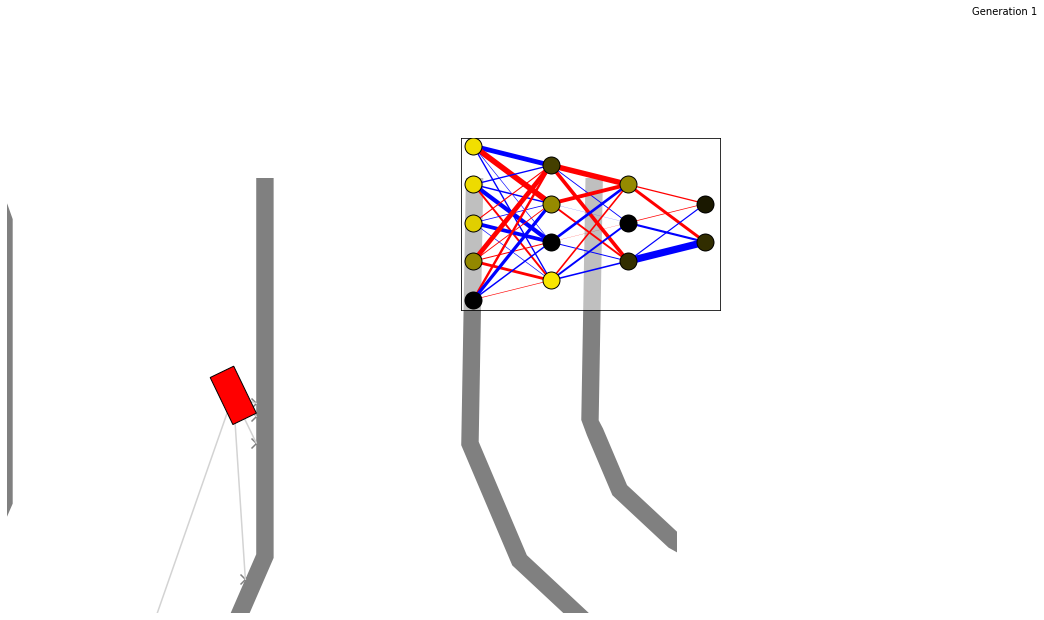

Starting with 0
2 0 17
Starting with 1
2 1 23
Starting with 2
2 2 10
Starting with 3
2 3 19
Starting with 4
2 4 18
Starting with 5
2 5 13
Starting with 6
2 6 18
Starting with 7
2 7 13
Starting with 8
2 8 11
Starting with 9
2 9 13
Starting with 10


KeyboardInterrupt: 

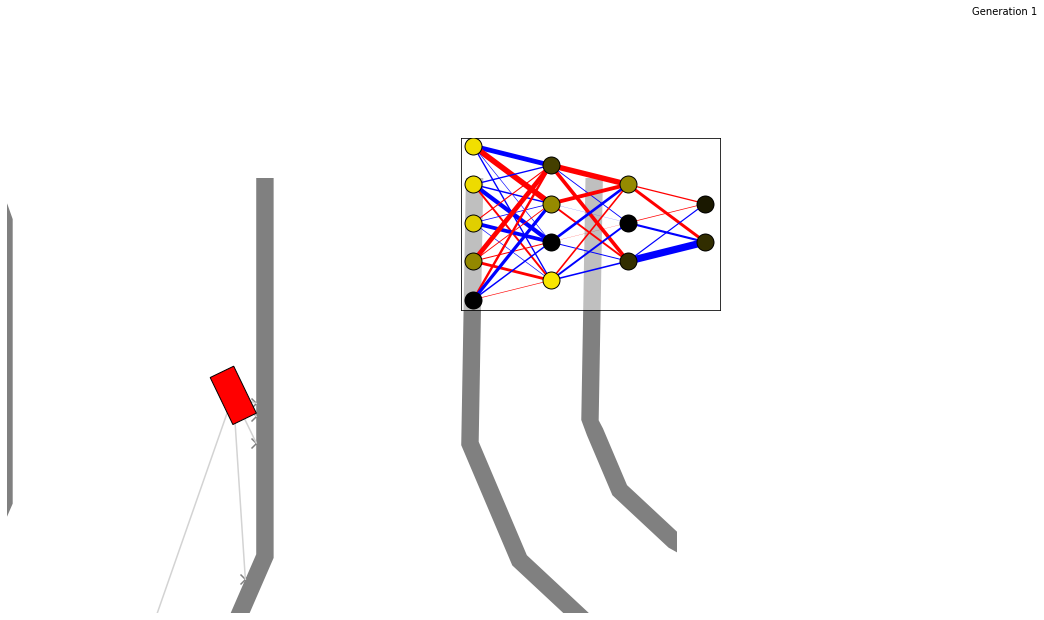

In [10]:
import copy
from time import sleep

DELT = 0.1

np.random.seed(2)

env = EnvironmentVid()
env.delt = DELT
env.maxsteps = 40 / DELT

file_k = 0

plt.figure(figsize=(16, 6))
gpool = genpool()

for k in range(NUM_GENERATIONS):
    records_tmp = { 'car': [[] for _ in range(NUM_POPULATION)],
                'obs':  [[] for _ in range(NUM_POPULATION)],
                'raymarkers': [[] for _ in range(NUM_POPULATION)],
                'progress': [[] for _ in range(NUM_POPULATION)] }
    
    for i in range(NUM_POPULATION):
        gpool.fitness[i] = evaluate(i, gpool.chromosomes[i], records_tmp)
    
    winner = np.argmax(gpool.fitness)
    
    plt.clf()
    plt.hist(gpool.fitness);
    plt.show()
    
    gpool.reproduce()
    gpool.plot()
    plt.show()
    sleep(5)
    
    records = records_tmp
    render_population(records['car'], None, records['obs'], records['raymarkers'],
                      records['progress'], gpool.chromosomes, k)


ModuleNotFoundError: No module named 'logger'